* Navam Shrivastav 2019A7PS0092H
* Sukrit Kumar 2019AAPS0231H
* Shrikrishna Lolla 2019AAPS0345H

In [1]:
import numpy as np
import pandas as pd
import networkx as nx 
from networkx.generators.harary_graph import hnm_harary_graph

In [2]:
web_graph = nx.read_gpickle("web_graph.gpickle")

In [3]:
web_graph.nodes[10]['page_content']

'Business: Staples Profit Up, to Enter China Market  NEW YORK (Reuters) - Staples Inc. &lt;A HREF="http://www.investor.reuters.com/FullQuote.aspx?ticker=SPLS.O target=/stocks/quickinfo/fullquote"&gt;SPLS.O&lt;/A&gt;, the top U.S.  office products retailer, on Tuesday reported a 39 percent jump  in quarterly profit, raised its full-year forecast and said it  plans to enter the fast-growing Chinese market, sending its  shares higher.'

# Inverted Index

In [4]:
class InvertedIndex:
    """ InvertedIndex data structure class with insert, search and find functions"""
    def __init__(self):
        """
        Initializes the inverted index data structure.
        index: A dictionary that maps words to a list of doc_ids
        voc_list: A list of all the unique words in the index
        voc_count: The number of words in the index
        """
        self.index = {}
        self.voc_list = []
        self.voc_count = 0
    
    def insert(self,word,doc_id):
        """
        Inserts a word into the inverted index and adds a doc_id to the list 
        Args: word, doc_id
        """
        if word not in self.index:
            self.index[word] = [doc_id]
            if word[-1] == "$":
              self.voc_list.append(word)
            self.voc_count += 1
        if doc_id not in self.index[word]:
          self.index[word].append(doc_id)
    def search(self,word):
      """
      Searches the inverted index for a word and returns the list of doc_ids
      \n used in case of wildcard queries
      \n Args: word
      """
      final_output = []
      word_list = []
      for w in self.index.keys():
        if w.startswith(word):
          word_list.append(get_main(w))
          final_output.extend( self.index[w] )
      return final_output,word_list
    def find(self,word):
        """
        Find if a word exists in the inverted index
        and returns the list of doc_ids otherwise None
        \n used in case of regular queries 
        \n Args: word
        """
        if word in self.index:
            return self.index[word]
        else:
            return None
    def getSize(self):
      """
      Returns the number of words in the inverted index
      """
      return len(self.index)


In [ ]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from itertools import permutations
nltk.download('stopwords')
nltk.download('punkt')

def tokenize(s):
    """ Tokenize the string using word_tokenize from nltk """
    return word_tokenize(s)

stopwords = nltk.corpus.stopwords.words('english')
def remove_stop_words(s):
    """ Use nltk english stopwords and remove such tokens from our list """
    stop_words = set(stopwords)
    filtered_list = [w for w in s if w not in stop_words]
    return filtered_list

def stem_words(word_list):
    """ Use the snowball stemming """ 
    stemmer = SnowballStemmer("english")
    stemmed_words = []
    for word in word_list:
        stemmed_words.append(stemmer.stem(word))
    return stemmed_words

lemmatizer = WordNetLemmatizer()
def lemmatize(s):
    """ Lemmatization using the WordNet lemmatizer """ 

    return lemmatizer.lemmatize(s)

def rotateString(s, n):
    """ rotate string to the left by n places """
    return s[n:] + s[:n]

In [9]:
import pickle
def preProcess(G):
    """ Main function to generate the inverted index """ 
    i_index = InvertedIndex()
    
    print(f"Total no of nodes is {len(G)}")
    global doc_count
    doc_count = len(G)
    for node in G.nodes():
        text = G.node[node]['page_content']
        text = text.lower()
        tokens = tokenize(text) # tokenize
        rm_data = remove_stop_words(tokens) # remove stopwords
        stemmed = stem_words(rm_data) # perform stemming
        for w in stemmed:
          i_index.insert(w,node)
    i_Index_save = open('output_index_final', 'ab')
    pickle.dump(i_index, i_Index_save) # Save the generated index for later use                     
    i_Index_save.close()
    return i_index

In [10]:
index = preProcess(web_graph)

Total no of nodes is 100


In [11]:
def not_oper(l,size):
  """
  negate the list and create a new list with all elements in space size 
  and not in l
  """
  l_not = []
  for i in range(1,size+1):
    if i not in l:
      l_not.append(i)
  return l_not

In [12]:
def or_op(l1,l2):
  """
  perform the or operation on the two lists
  """
  for i in l2:
    if i not in l1:
      l1.append(i)
  return l1


In [13]:

def and_op(l1,l2):
  """
  perform the and intersection on the two lists
  """
  i = 0
  j = 0
  intersection = []
  while i < len(l1) and j < len(l2):
    if(l1[i] == l2[j]):
      intersection.append(l1[i])
      i += 1
      j += 1
    elif (l1[i] < l2[j]):
      i += 1
    else:
      j += 1
  return intersection

In [14]:
def retrieve(query):
  """
  Query retrival function
  take query input from user
  tokenize it
  then create a retrival list and perform operations.
  """
  query = tokenize(query)
  #query = remove_stop_words(query)
  query = stem_words(query)
  print(query)
  retrival_list = []
  connect = []
  wc = 0
  conn = ["and","or","not"]
  for q in query:
    if q in conn:
      connect.append(q)
      continue
    # don't correct wildcard queries 
    if "*" in q:
      wc = 0
      while(q[-1] != '*'):
        q = rotateString(q,1)
      l,l_w = index.search(q[:-1])
      l = list(set(l))
      print(f"Words returned for wildcard query {q} is {l_w}")
    else:
      l = index.find(q)
    if l:
      print(f"Query is {q} and list of docs are {l}")
    else:
      l = []
      print("No result found")
    if len(connect) >= 1 and connect[-1] == "not$":
      temp_cp = not_oper(l.copy(),doc_count)
      retrival_list.append(temp_cp)
    else:
      retrival_list.append(l.copy())
  if len(retrival_list) > 1:
    i_1 = 0
    i_2 = 1
    i = 0
    for con in connect:
      if con == "and":
        comp = and_op(retrival_list[i_1],retrival_list[i_2])
        temp_cp = retrival_list[2:]
        retrival_list = [comp]
        retrival_list.extend(temp_cp)
      elif con == "or":
        comp = or_op(retrival_list[i_1],retrival_list[i_2])
        temp_cp = retrival_list[2:]
        retrival_list = [comp]
        retrival_list.extend(temp_cp)
        i += 1
      elif con == "not":
        continue
  if len(query) == 0:
    return []
  return retrival_list

In [15]:
retrieve("China and Business")[0]

['china', 'and', 'busi']
Query is china and list of docs are [10, 20, 85, 95]
Query is busi and list of docs are [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]


[10, 20]

# HITS

In [4]:
def getRootSet(G,query):
    """
    Function to generate the root set for a given query
    Inputs : 
    G -> Graph
    query -> Query
    Returns :
    returns all the nodes satisfying the particular query
    """
    nodes = []
    if(len(query.split()) > 1):
        return retrieve(query)[0]
    for pos,data in G.nodes(data=True):
        if query in data['page_content']:
            print(pos)
            print(f"Incoming edges : {G.in_edges(pos)}")
            for e in G.predecessors(pos):
                print(e)
            print(f"Outgoing edges : {G.out_edges(pos)}")
            for e in G.successors(pos):
                print(e)
            nodes.append(pos)
    return nodes
    

In [5]:
rootSet = getRootSet(web_graph,"China")
print(rootSet)

10
Incoming edges : [(3, 10)]
3
Outgoing edges : [(10, 0), (10, 61), (10, 75)]
0
61
75
20
Incoming edges : [(19, 20), (95, 20)]
19
95
Outgoing edges : [(20, 95)]
95
85
Incoming edges : []
Outgoing edges : [(85, 84)]
84
95
Incoming edges : [(71, 95), (20, 95)]
71
20
Outgoing edges : [(95, 19), (95, 20), (95, 43)]
19
20
43
[10, 20, 85, 95]


In [6]:
def getBaseSet(G,rootSet):
    """
    Function returns the base set for a given graph and rootset
    Input:
    G -> graph
    rootSet ->rootSet
    Returns:
    nodes -> corresponding to the base set for given graph and rootset
    """
    nodes = []
    for node in rootSet:
        nodes.append(node)
        for e in G.predecessors(node):
            nodes.append(e)
        for e in G.successors(node):
            nodes.append(e)
    return nodes

In [7]:
baseSet = list(set(getBaseSet(web_graph,rootSet)))

In [8]:
baseSet

[0, 3, 71, 10, 75, 43, 19, 20, 85, 84, 61, 95]

In [9]:
H = web_graph.subgraph(baseSet)

In [10]:
A = nx.adjacency_matrix(H).todense()
print(A.shape)

(12, 12)


In [11]:
def getPrincipalEV(P):
    """
    Compute the left eigen vector for a given probability translation matrix using numpy
    """
    values, Vector = np.linalg.eig(np.array(P).T)
    left_vec = Vector[:, np.argmax(values)].T
    left_vec_norm = (left_vec/left_vec.sum()).real
    return left_vec_norm

In [12]:
def power_iteration_iter(prob_matrix, max_iter=100):
    """
    Compute the left eigen vector using the power iteration method
    Inputs: prob_matrix
    max_iters (optional) defaults to 100
    """
    n = prob_matrix.shape[0]
    eigen_vector = np.ones((n,1))
    for i in range(max_iter):
        eigen_vector = prob_matrix@eigen_vector
        eigen_vector = eigen_vector/np.sum(eigen_vector)
    return eigen_vector

In [13]:
def HITS(G,iters = 0):
    """
    Hyperlink-Induced Topic Search (HITS; also known as hubs and authorities) 
    Input :
    G -> Graph
    return :
    Hub and Authorities score for given set of nodes
    """
    A = nx.adjacency_matrix(G).todense()
    print(A.shape)
    n = A.shape[0]
    A = A.astype('float64')
    if iters == 0:
        h= getPrincipalEV(A@A.T)
        a= getPrincipalEV(A.T@A)
    else:
        h = power_iteration_iter(A@A.T,iters)
        a = power_iteration_iter(A.T@A,iters)
    h = h.flatten()
    h_new = np.squeeze(np.asarray(h))
    a_new = np.squeeze(np.asarray(a))
    hubs = dict(zip(G, map(float, h_new)))
    authorities = dict(zip(G, map(float, a_new)))
    return hubs,authorities

In [14]:
h, a = nx.hits(H)

In [18]:
h_1,a_1 = HITS(H,100)

(12, 12)


In [19]:
a_1

{0: 0.2928932188134525,
 3: 0.2426406871192851,
 71: 0.0,
 10: 0.0,
 75: 0.17157287525380985,
 43: 0.0,
 19: 0.0,
 20: 0.0,
 85: 0.0,
 84: 0.0,
 61: 0.2928932188134525,
 95: 0.0}

In [17]:
a

{0: 0.2928932143652156,
 3: 0.24264068343424505,
 71: 0.0,
 10: 2.0075934070464737e-45,
 75: 0.17157287264809307,
 43: 4.448236875154756e-09,
 19: 4.448236875154756e-09,
 20: 6.290756917491971e-09,
 85: 0.0,
 84: 2.0075934070464737e-45,
 61: 0.2928932143652156,
 95: 1.185073977083293e-24}

In [20]:
h

{0: 0.29289321537292334,
 3: 1.0979892973488558e-45,
 71: 6.481384820437286e-25,
 10: 0.41421355750745203,
 75: 0.29289321537292334,
 43: 0.0,
 19: 3.440529214424526e-09,
 20: 6.481384820437286e-25,
 85: 1.0979892973488558e-45,
 84: 0.0,
 61: 0.0,
 95: 8.306172291204543e-09}

In [21]:
h_1

{0: 0.29289321881345276,
 3: 0.0,
 71: -4.672732250081421e-17,
 10: 0.414213562373095,
 75: 0.2928932188134525,
 43: 0.0,
 19: 0.0,
 20: -1.5505532080427557e-16,
 85: 0.0,
 84: 0.0,
 61: 0.0,
 95: 0.0}

In [21]:
hub_sorted = sorted(h_1.items(), key=lambda x: x[1], reverse=True)
auth_sorted = sorted(a_1.items(),key=lambda x: x[1],reverse=True)

In [22]:
hub_sorted[0:3]

[(10, 0.41421356237140183), (0, 0.2928932188122552), (75, 0.2928932188122552)]

In [23]:
auth_sorted[0:3]

[(61, 0.2928932188119046), (0, 0.29289321881190455), (3, 0.24264068711800282)]

# Visualization

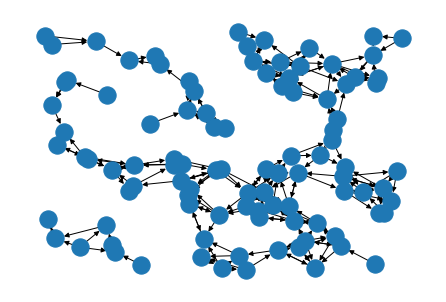

In [25]:
pos = {i: web_graph.nodes[i]['pos'] for i in range(len(web_graph.nodes))}
nx.draw(web_graph, pos) # Draw the original web graph

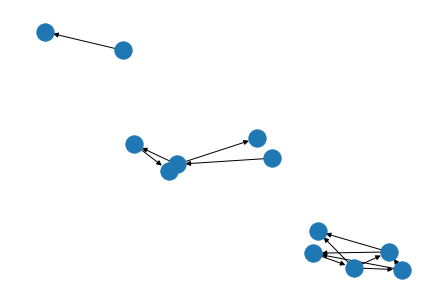

In [26]:
nx.draw(H,pos) # Draw the sub graph